In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [3]:
dataset_asimov = Dataset_load.create_asimov()

In [4]:
print(dataset_asimov.psf)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (60, 60, 66, 24)
	ndim  : 4
	unit  : 1 / sr
	dtype : >f4



<Axes: xlabel='True Energy [TeV]', ylabel='Containment radius (deg)'>

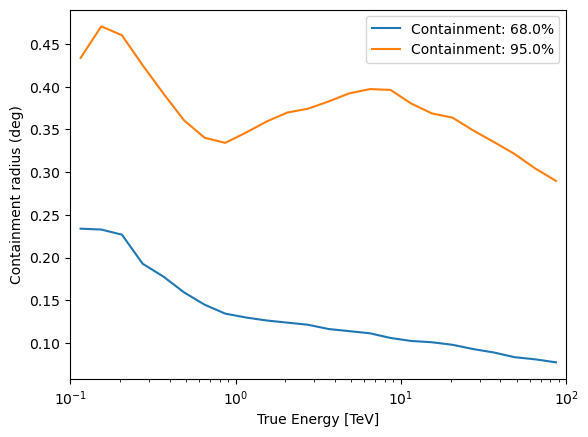

In [5]:
dataset_asimov.psf.plot_containment_radius_vs_energy()

<Axes: xlabel='Rad (deg)', ylabel='PSF (None)'>

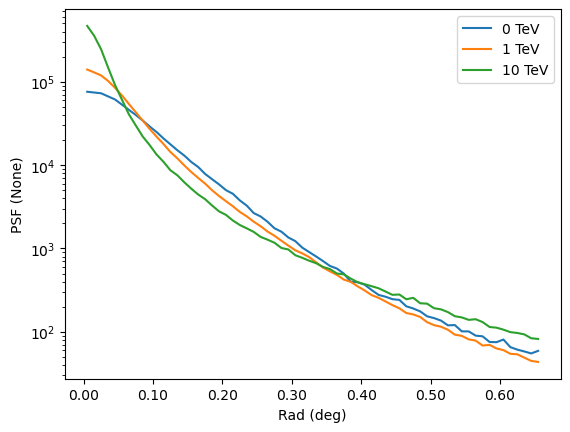

In [6]:
dataset_asimov.psf.plot_psf_vs_rad(energy_true = [0.5, 1, 10] *u.TeV)

<WCSAxes: >

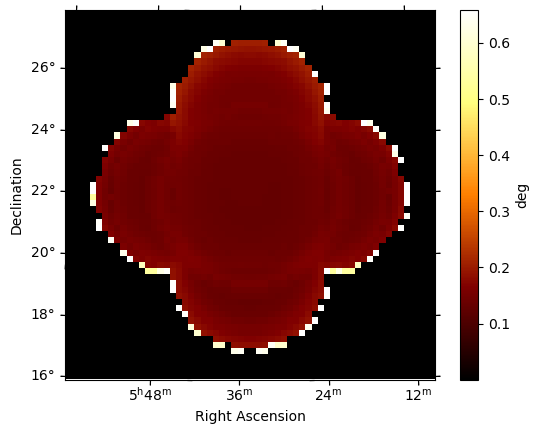

In [7]:
dataset_asimov.psf.containment_radius_map(1*u.TeV).plot(add_cbar = 1)

### How does it get evaluated?

<WCSAxes: >

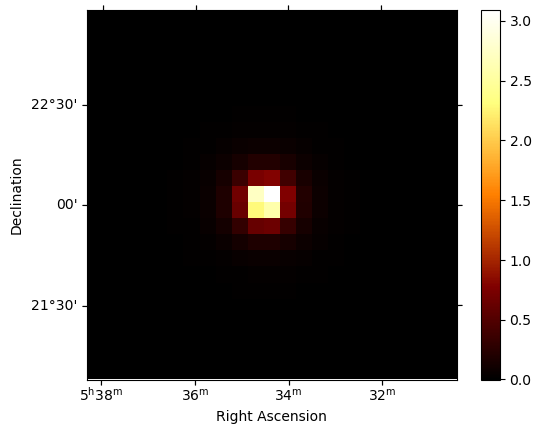

In [8]:
dataset_asimov.evaluators['Source'].compute_flux_spatial().sum_over_axes().plot(add_cbar=1)

In [29]:
from gammapy.irf import PSFMap, PSFKernel

def create_gaussian(psf, sigma, rad = dataset_asimov.psf.psf_map.geom.axes['rad'],
                   geom = dataset_asimov.psf.psf_map.geom.to_image()):

    psf_g = PSFMap.from_gauss(energy_axis_true = psf.psf_map.geom.axes['energy_true'],
                        sigma = sigma*u.deg,
                          geom =geom ,
                          rad_axis = rad,
                         )
    return psf_g



g## Understanding the PSFMap

In [30]:
psf_g = create_gaussian(dataset_asimov.psf, 0.1)
psf_g_2 = create_gaussian(dataset_asimov.psf, 0.2)

In [31]:
geom = psf_g.psf_map.geom
coords = geom.get_coord(sparse=True)
rad = coords.skycoord.separation(geom.center_skydir)
rad.shape

(1, 1, 60, 60)

In [32]:
type(dataset_asimov.psf)

gammapy.irf.psf.map.PSFMap

In [33]:
from astropy.visualization import quantity_support
from matplotlib.ticker import FormatStrFormatter
def plot_psf_vs_rad(psf, ax=None, energy_true=[0.1, 1, 10] * u.TeV,energy_name='energy', label = None,**kwargs):
    """Plot PSF vs radius.

    The method plots the profile at the center of the map.

    Parameters
    ----------
    ax : `~matplotlib.pyplot.Axes`
        Axes to plot on.
    energy : `~astropy.units.Quantity`
        Energies where to plot the PSF.
    **kwargs : dict
        Keyword arguments pass to `~matplotlib.pyplot.plot`.

    Returns
    -------
    ax : `~matplotlib.pyplot.Axes`
         Axes to plot on.

    """
    ax = plt.gca() if ax is None else ax

    rad = psf.psf_map.geom.axes["rad"].center

    for value in energy_true:
        psf_value = psf.psf_map.interp_by_coord(
            {
                "skycoord": psf.psf_map.geom.center_skydir,
                energy_name: value,
                "rad": rad,
            }
        )
        if label is None:
            label = f"{value:.0f}"
        with quantity_support():
            ax.plot(rad**2, psf_value, label=label, **kwargs)

    ax.set_yscale("log")
    ax.set_xlabel(f"Rad **2  ({ax.xaxis.units})")
    ax.set_ylabel(f"PSF ({ax.yaxis.units})")
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.legend()
    return ax

<Axes: xlabel='Rad **2  (deg2)', ylabel='PSF (None)'>

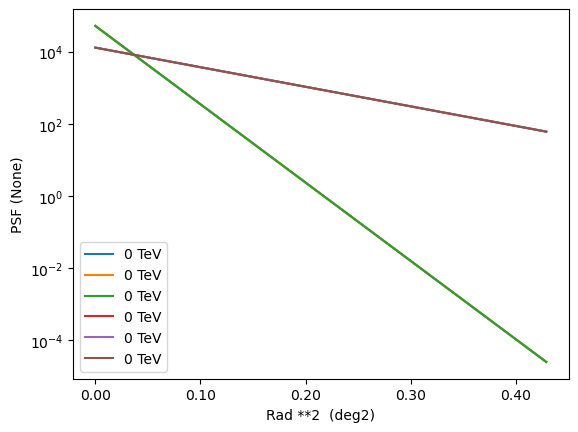

In [34]:
#plot_psf_vs_rad(dataset_asimov.psf, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true')
plot_psf_vs_rad(psf_g, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true')
plot_psf_vs_rad(psf_g_2, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true')


0.9999999999999999
WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (11, 11, 1)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 0.9 deg x 0.9 deg
	wcs ref    : 83.6 deg, 22.0 deg



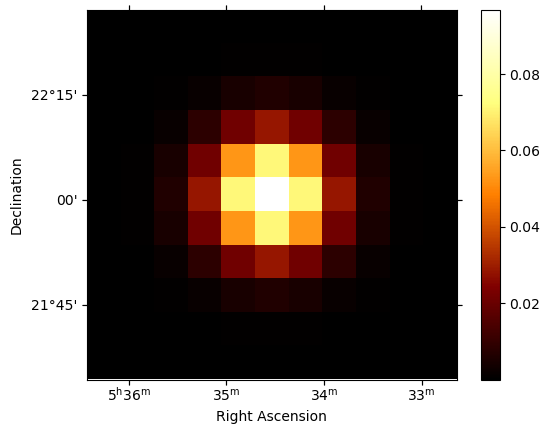

In [35]:
psf_kernel = psf_g.get_psf_kernel(dataset_asimov.exposure.geom)
psf_kernel.to_image().psf_kernel_map.plot(ax=None, add_cbar=1)
print(psf_kernel.to_image().psf_kernel_map.data.sum())
print(psf_kernel.to_image().psf_kernel_map.geom)

1.0
WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (17, 17, 1)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 1.4 deg x 1.4 deg
	wcs ref    : 83.6 deg, 22.0 deg



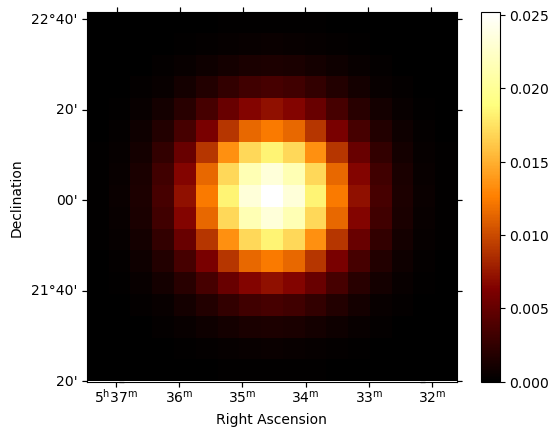

In [36]:
psf_kernel2 = psf_g_2.get_psf_kernel(dataset_asimov.exposure.geom)
psf_kernel2.to_image().psf_kernel_map.plot(ax=None, add_cbar=1)
print(psf_kernel2.to_image().psf_kernel_map.data.sum())
print(psf_kernel2.to_image().psf_kernel_map.geom)

0.9999999999999999
WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (17, 17, 1)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 1.4 deg x 1.4 deg
	wcs ref    : 83.6 deg, 22.0 deg



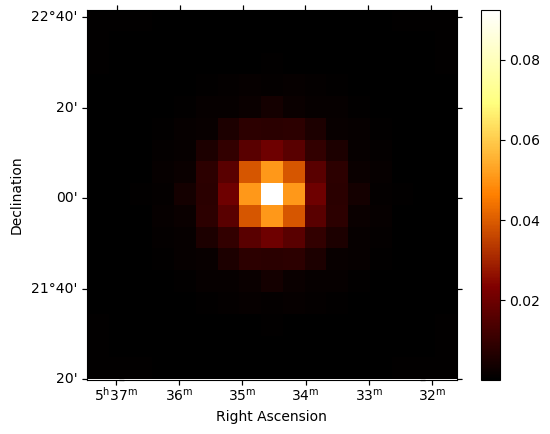

In [37]:
psf_kerneltrue= dataset_asimov.psf.get_psf_kernel(dataset_asimov.exposure.geom)
psf_kerneltrue.to_image().psf_kernel_map.plot(ax=None, add_cbar=1)
print(psf_kerneltrue.to_image().psf_kernel_map.data.sum())
print(psf_kerneltrue.to_image().psf_kernel_map.geom)

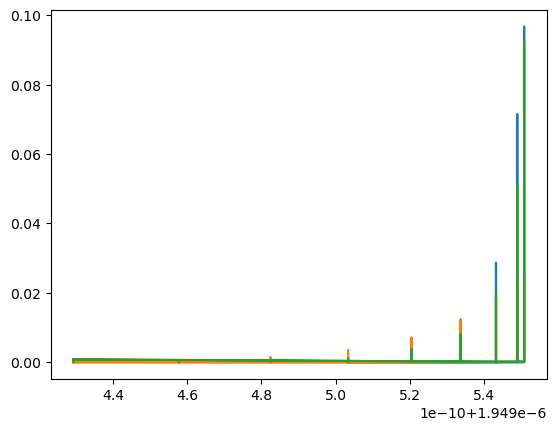

In [38]:
plt.plot(psf_kernel.to_image().psf_kernel_map.geom.solid_angle().flatten(),
        psf_kernel.to_image().psf_kernel_map.data.flatten())
plt.plot(psf_kernel2.to_image().psf_kernel_map.geom.solid_angle().flatten(),
         psf_kernel2.to_image().psf_kernel_map.data.flatten())
plt.plot(psf_kerneltrue.to_image().psf_kernel_map.geom.solid_angle().flatten(),
         psf_kerneltrue.to_image().psf_kernel_map.data.flatten())

<Axes: xlabel='Rad (deg)', ylabel='PSF (None)'>

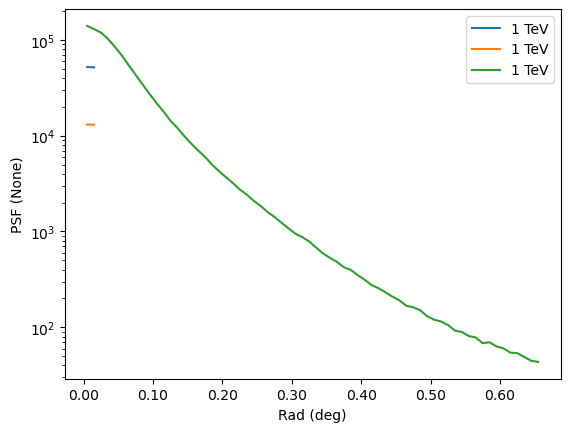

In [20]:
ax = psf_g.plot_psf_vs_rad(energy_true = [1] *u.TeV, )
psf_g_2.plot_psf_vs_rad(energy_true = [1] *u.TeV, ax = ax)
dataset_asimov.psf.plot_psf_vs_rad(energy_true = [1] *u.TeV, ax = ax)

<Axes: xlabel='Rad **2  (deg2)', ylabel='PSF (None)'>

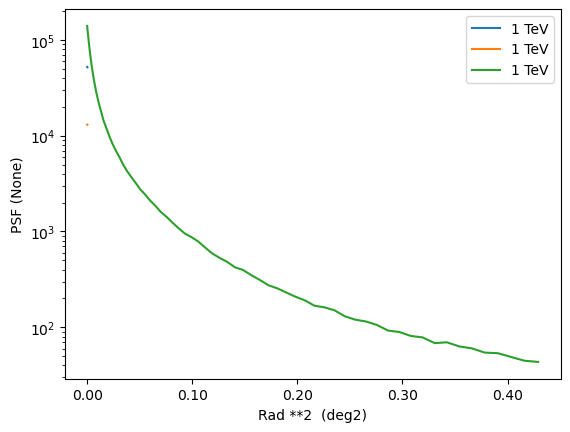

In [21]:
plot_psf_vs_rad(psf_g, ax=None, energy_true=[1] * u.TeV,energy_name='energy_true')
plot_psf_vs_rad(psf_g_2, ax=None, energy_true=[1] * u.TeV,energy_name='energy_true')
plot_psf_vs_rad(dataset_asimov.psf, ax=None, energy_true=[1] * u.TeV,energy_name='energy_true')



## test: the double convolution **

<WCSAxes: >

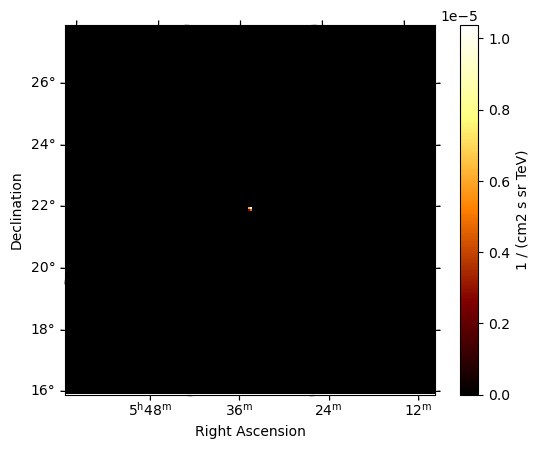

In [22]:
flux = Map.from_geom(geom = dataset_asimov.exposure.geom,
                     data = dataset_asimov.models[0].evaluate_geom(dataset_asimov.exposure.geom))
flux.sum_over_axes().plot(add_cbar = 1)

False


<WCSAxes: >

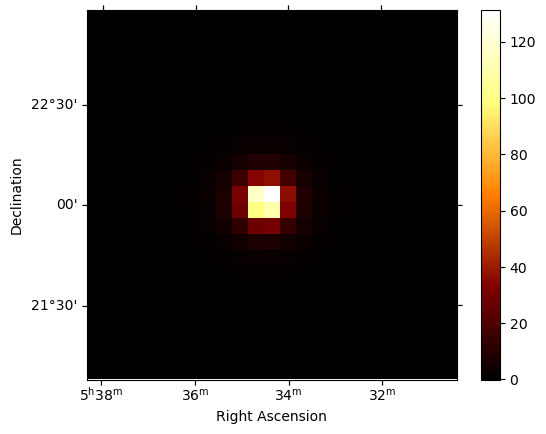

In [23]:
evalu = dataset_asimov.evaluators[dataset_asimov.models[0].name]
evalu.model.apply_irf['psf'] = False
print(evalu.model.apply_irf["psf"])
npred_no_psf = evalu.compute_npred()
npred_no_psf.sum_over_axes().plot(add_cbar = 1)



True


<WCSAxes: >

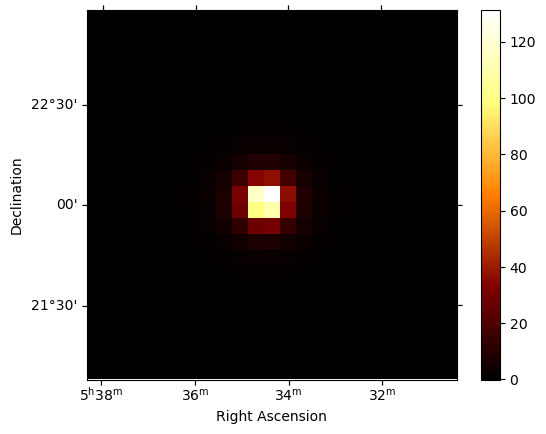

In [24]:
evalu = dataset_asimov.evaluators[dataset_asimov.models[0].name]
evalu.model.apply_irf['psf'] = True
print(evalu.model.apply_irf["psf"])
npred_yes_psf = evalu.compute_npred()
npred_yes_psf.sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

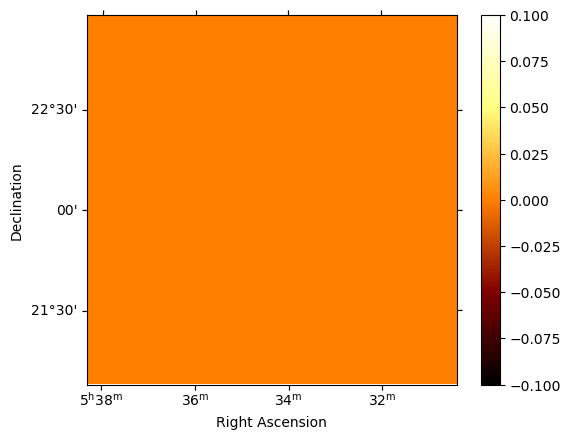

In [25]:
(npred_yes_psf- npred_no_psf).sum_over_axes().plot(add_cbar = 1)



In [26]:
psf_gtest = psf_g.copy()
#psf_gtest.psf_map.data *= psf_g_2.psf_map.data 

24.0


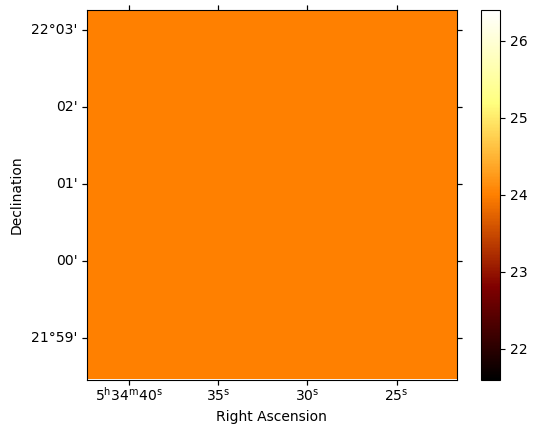

In [27]:
psf_kerneltest = psf_kernel.psf_kernel_map.convolve(psf_kernel2)

psf_kerneltest.sum_over_axes().plot(ax=None, add_cbar=1)
print(psf_kerneltest.sum_over_axes().data.sum())


In [28]:
plt.plot(psf_kerneltest.to_image().psf_kernel_map.data[0,:,10])
plt.plot(psf_kernel2.to_image().psf_kernel_map.data[0,:,10])
plt.plot(psf_kernel.to_image().psf_kernel_map.data[0,:,10])

AttributeError: 'WcsNDMap' object has no attribute 'to_image'

In [ ]:
plt.plot(psf_kernel.to_image().psf_kernel_map.geom.solid_angle().flatten(),
        psf_kernel.to_image().psf_kernel_map.data.flatten())
plt.plot(psf_kernel2.to_image().psf_kernel_map.geom.solid_angle().flatten(),
         psf_kernel2.to_image().psf_kernel_map.data.flatten())
plt.plot(psf_kerneltest.to_image().psf_kernel_map.geom.solid_angle().flatten(),
         psf_kerneltest.to_image().psf_kernel_map.data.flatten())

In [ ]:
ax = dataset_asimov.psf.plot_psf_vs_rad(energy_true = [0.5, 1, 10] *u.TeV)
psf_g = create_gaussian(dataset_asimov.psf, 0.1)
psf_g.plot_psf_vs_rad(energy_true = [0.5, 1, 10] *u.TeV, ax = ax)

In [ ]:
def normalize(t, base):
    """Force normalisation of the kernel"""
    data = t.data
    if t.geom.is_image:
        axis = (0, 1)
    else:
        axis = (1, 2)

    data = np.nan_to_num(data / base.data.sum(axis=axis, keepdims=True))
    t.data = data

In [ ]:
dataset_bad = Dataset_load.create_asimov()
normalize(psf_g.psf_map, dataset_asimov.psf.psf_map)
dataset_bad.psf = psf_g


In [ ]:
n=dataset_asimov.npred_signal().sum_over_axes()
n.plot(add_cbar=1)

In [ ]:
nb = dataset_bad.npred_signal().sum_over_axes()
nb.plot(add_cbar=1)

#### Shifting up

In [ ]:
def create_uni(value,psf):
    psf_uni = psf.copy()
    psf_uni.psf_map.data = value
    return psf_uni

In [ ]:
ee = np.linspace(0.9, 1.1, (psf_uni.psf_map.data.shape[1]))
len(ee)

In [ ]:
psf_uni.psf_map.data[:,e,:,:]

In [ ]:
for e in range(len(ee)):
    psf_uni.psf_map.data[:,e,:,:] *= ee[e]

In [ ]:
for e in range(len(ee)):
    plt.plot(psf_uni.psf_map.data[:,e,:,:] )

In [ ]:
psf_uni.psf_map.data.shape

In [ ]:
psf_uni.psf_map.data[:,:,5,:]

In [ ]:
psf_uni = create_uni(1, psf_g)


In [ ]:
enes = [1] *u.TeV

psf_g = create_gaussian(dataset_asimov.psf, 1.)
t = dataset_asimov.psf.copy()
psf_g_norm = psf_g.copy()
psf_g_norm.psf_map.data /= psf_g.psf_map.data.sum(axis=(1,2), keepdims=True)
t.psf_map.data *= psf_uni.psf_map.data 
#t.psf_map.data *= dataset_asimov.psf.psf_map.data

plot_psf_vs_rad(dataset_asimov.psf, ax=None, energy_true=enes,energy_name='energy_true',
               label = "Data")
plot_psf_vs_rad(psf_g, ax=None, energy_true=enes,energy_name='energy_true',
               label = 'Gauss')
plot_psf_vs_rad(psf_g_norm, ax=None, energy_true=enes,energy_name='energy_true',
                label = "gauss norm")

plot_psf_vs_rad(t, ax=None, energy_true=enes,energy_name='energy_true',
               label = 'multi')
plot_psf_vs_rad(psf_uni, ax=None, energy_true=enes,energy_name='energy_true',
               label = 'uni')


In [ ]:
dataset_shift = Dataset_load.create_asimov()
dataset_shift.psf = t

In [ ]:
nt=dataset_shift.npred_signal().sum_over_axes()
nt.plot(add_cbar=1)

In [ ]:
plt.plot(n.data[:,:,75][0], label=f'data, {n.data.sum():.5}')
plt.plot(nb.data[:,:,75][0], label =f'gaussian, {nb.data.sum():.5}')
plt.plot(nt.data[:,:,75][0], label = f'data * gaussian, {nt.data.sum():.5}')

plt.plot(n.data[:,:,74][0], label=f'', linestyle= 'dotted',
        color = 'tab:blue', linewidth = 12)
plt.plot(nb.data[:,:,74][0], label =f'', linestyle= 'dotted',
        color = 'tab:orange')
plt.plot(nt.data[:,:,74][0], label = f'', linestyle= 'dotted',
        color = 'tab:green')
plt.legend()
plt.xlim(60, 90)

In [ ]:
(n-nb).plot(add_cbar = 1)

In [ ]:
(n-nt).plot(add_cbar = 1)